In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%load_ext autotime

time: 0 ns (started: 2021-03-29 13:36:03 -05:00)


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
time: 1.78 s (started: 2021-03-29 13:36:10 -05:00)


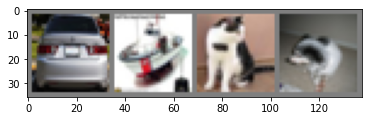

  car  ship   cat   dog
time: 2.72 s (started: 2021-03-29 13:36:18 -05:00)


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

time: 16 ms (started: 2021-03-29 13:36:26 -05:00)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.ASGD(net.parameters(), lr=0.001)

time: 0 ns (started: 2021-03-29 13:36:42 -05:00)


In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.304
[1,  4000] loss: 2.302
[1,  6000] loss: 2.300
[1,  8000] loss: 2.296
[1, 10000] loss: 2.288
[1, 12000] loss: 2.259
[2,  2000] loss: 2.148
[2,  4000] loss: 2.061
[2,  6000] loss: 1.994
[2,  8000] loss: 1.951
[2, 10000] loss: 1.902
[2, 12000] loss: 1.845
Finished Training
time: 1min 33s (started: 2021-03-29 13:36:52 -05:00)


In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

time: 0 ns (started: 2021-03-29 13:38:31 -05:00)


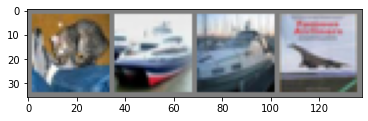

GroundTruth:    cat  ship  ship plane
time: 1.45 s (started: 2021-03-29 13:38:43 -05:00)


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

time: 16 ms (started: 2021-03-29 13:38:48 -05:00)


In [10]:
outputs = net(images)

time: 0 ns (started: 2021-03-29 13:38:53 -05:00)


In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship  ship  ship
time: 0 ns (started: 2021-03-29 13:38:59 -05:00)


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 32 %
time: 5.14 s (started: 2021-03-29 13:39:04 -05:00)


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car : 31 %
Accuracy of  bird :  5 %
Accuracy of   cat :  2 %
Accuracy of  deer : 10 %
Accuracy of   dog : 29 %
Accuracy of  frog : 50 %
Accuracy of horse : 42 %
Accuracy of  ship : 52 %
Accuracy of truck : 50 %
time: 4.92 s (started: 2021-03-29 13:39:14 -05:00)
